<a href="https://colab.research.google.com/github/Yisahak/Yisahak/blob/main/traffic_Volume_prediction_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
path = "/content/drive/MyDrive/fall22/datamining/MicrowavefaultPrediction/"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [70]:
# Import all necessary libraries.
import numpy as np
import pandas as pd
from sklearn  import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns
sns.set_theme()

In [69]:
# Hyper parameters
########
num_of_feature = 8 # number of input features for LSTM and GRU network
past_observation = 12 # Number of past hours data used as input to the LSTM and GRU network
##########

######## Model Parameters # 
hidden_layers_unit = [128, 64,32,16]
return_sequence = [True, True, True,False]
batch_size = 64
num_of_epoch = 300



# Read dataset

In [71]:
# Import Dataset

mw_data = pd.read_csv("/content/MW_LOG new1.csv")
mw_data.head()

,Date,Severity_id,RTN_id,OptiX RTN 905,OptiX RTN 980,OptiX RTN 950A,OptiX RTN 380A,OptiX RTN 380AX,A3,F2,G2,I2,I3,J3,K3,L2,M2,T2
0,11/10/2022 15:49,3,146,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,11/10/2022 15:49,3,640,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,11/10/2022 15:51,3,1349,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
3,11/10/2022 15:52,1,688,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,11/10/2022 15:53,3,19,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [72]:
mw_data['Fault_Type'] = mw_data['A3'].astype('str') + mw_data['F2'].astype('str') + mw_data['G2'].astype('str') + mw_data['I2'].astype('str') + mw_data['I3'].astype('str') + mw_data['J3'].astype('str') + mw_data['K3'].astype('str') + mw_data['L2'].astype('str') + mw_data['M2'].astype('str') + mw_data['T2'].astype('str')
mw_data.head()

,Date,Severity_id,RTN_id,OptiX RTN 905,OptiX RTN 980,OptiX RTN 950A,OptiX RTN 380A,OptiX RTN 380AX,A3,F2,G2,I2,I3,J3,K3,L2,M2,T2,Fault_Type
0,11/10/2022 15:49,3,146,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0000000010
1,11/10/2022 15:49,3,640,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0000100000
2,11/10/2022 15:51,3,1349,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0001000000
3,11/10/2022 15:52,1,688,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0000000100
4,11/10/2022 15:53,3,19,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0000000010


In [73]:
mw_data['Date'] = pd.to_datetime(mw_data['Date'], infer_datetime_format= True)

In [74]:
mw_data['year'] = mw_data.Date.dt.year
mw_data['month'] = mw_data.Date.dt.month
mw_data['Day_of_week'] = mw_data.Date.dt.dayofweek
mw_data['hour'] = mw_data.Date.dt.hour

In [75]:
mw_data.head()

,Date,Severity_id,RTN_id,OptiX RTN 905,OptiX RTN 980,OptiX RTN 950A,OptiX RTN 380A,OptiX RTN 380AX,A3,F2,...,J3,K3,L2,M2,T2,Fault_Type,year,month,Day_of_week,hour
0,2022-11-10 15:49:00,3,146,0,0,1,0,0,0,0,...,0,0,0,1,0,0000000010,2022,11,3,15
1,2022-11-10 15:49:00,3,640,0,0,1,0,0,0,0,...,0,0,0,0,0,0000100000,2022,11,3,15
2,2022-11-10 15:51:00,3,1349,0,0,1,0,0,0,0,...,0,0,0,0,0,0001000000,2022,11,3,15
3,2022-11-10 15:52:00,1,688,1,0,0,0,0,0,0,...,0,0,1,0,0,0000000100,2022,11,3,15
4,2022-11-10 15:53:00,3,19,0,0,1,0,0,0,0,...,0,0,0,1,0,0000000010,2022,11,3,15


In [76]:
mw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105697 entries, 0 to 105696
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Date             105697 non-null  datetime64[ns]
 1   Severity_id      105697 non-null  int64         
 2   RTN_id           105697 non-null  int64         
 3   OptiX RTN 905    105697 non-null  int64         
 4   OptiX RTN 980    105697 non-null  int64         
 5   OptiX RTN 950A   105697 non-null  int64         
 6   OptiX RTN 380A   105697 non-null  int64         
 7   OptiX RTN 380AX  105697 non-null  int64         
 8   A3               105697 non-null  int64         
 9   F2               105697 non-null  int64         
 10  G2               105697 non-null  int64         
 11  I2               105697 non-null  int64         
 12  I3               105697 non-null  int64         
 13  J3               105697 non-null  int64         
 14  K3               105

In [77]:
mw_data = mw_data.drop(mw_data.columns[[8, 9, 10, 11, 12, 13, 14, 15, 16, 17]], axis=1)  # df.columns is zero-based pd.Index
mw_data.head()

,Date,Severity_id,RTN_id,OptiX RTN 905,OptiX RTN 980,OptiX RTN 950A,OptiX RTN 380A,OptiX RTN 380AX,Fault_Type,year,month,Day_of_week,hour
0,2022-11-10 15:49:00,3,146,0,0,1,0,0,0000000010,2022,11,3,15
1,2022-11-10 15:49:00,3,640,0,0,1,0,0,0000100000,2022,11,3,15
2,2022-11-10 15:51:00,3,1349,0,0,1,0,0,0001000000,2022,11,3,15
3,2022-11-10 15:52:00,1,688,1,0,0,0,0,0000000100,2022,11,3,15
4,2022-11-10 15:53:00,3,19,0,0,1,0,0,0000000010,2022,11,3,15


In [78]:
# Checking for any missing or empty value
mw_data.isna().sum()

Date               0
Severity_id        0
RTN_id             0
OptiX RTN 905      0
OptiX RTN 980      0
OptiX RTN 950A     0
OptiX RTN 380A     0
OptiX RTN 380AX    0
Fault_Type         0
year               0
month              0
Day_of_week        0
hour               0
dtype: int64

# convert categorical to nominal data

In [79]:
# Convert categorical value to numerical values. For holiday attribute, value will be within by 0 and 1. If it is holiday then 1 otherwise 0
label_encoder = preprocessing.LabelEncoder()
mw_data['Fault_Type'] = label_encoder.fit_transform(mw_data['Fault_Type'])


In [80]:
mw_data.describe()

,Severity_id,RTN_id,OptiX RTN 905,OptiX RTN 980,OptiX RTN 950A,OptiX RTN 380A,OptiX RTN 380AX,Fault_Type,year,month,Day_of_week,hour
count,105697.000000,105697.000000,105697.000000,105697.000000,105697.000000,105697.000000,105697.000000,105697.000000,105697.000000,105697.000000,105697.000000,105697.000000
mean,2.365971,795.427467,0.428404,0.103040,0.467194,0.000927,0.000435,3.823874,2022.952080,2.648032,3.379963,11.732566
std,0.839146,502.991391,0.494850,0.304012,0.498925,0.030436,0.020857,2.601605,0.213598,2.112888,1.871120,6.134153
min,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022.000000,1.000000,0.000000,0.000000
25%,2.000000,241.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2023.000000,2.000000,2.000000,8.000000
50%,3.000000,808.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2023.000000,2.000000,4.000000,12.000000
75%,3.000000,1269.000000,1.000000,0.000000,1.000000,0.000000,0.000000,6.000000,2023.000000,3.000000,5.000000,16.000000
max,3.000000,1656.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,2023.000000,12.000000,6.000000,23.000000


<Axes: >

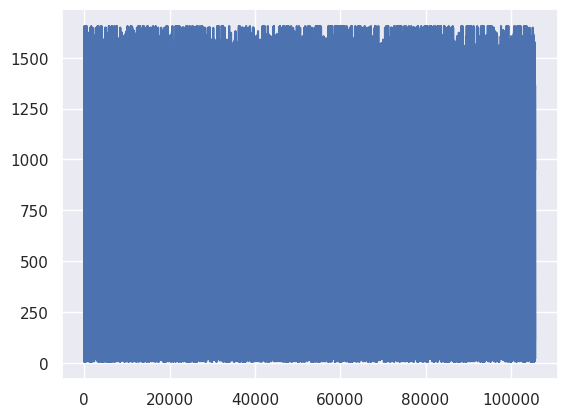

In [81]:
mw_data['RTN_id'].plot()

<Axes: >

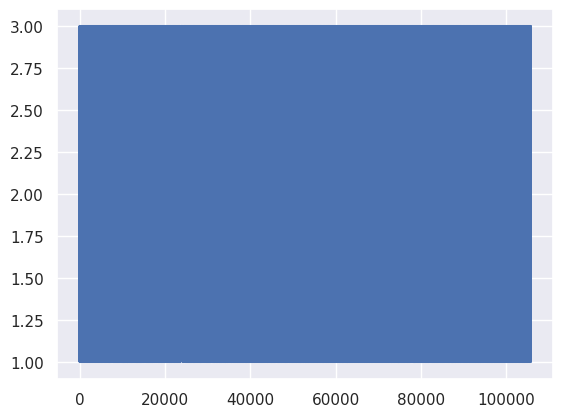

In [82]:
mw_data['Severity_id'].plot()

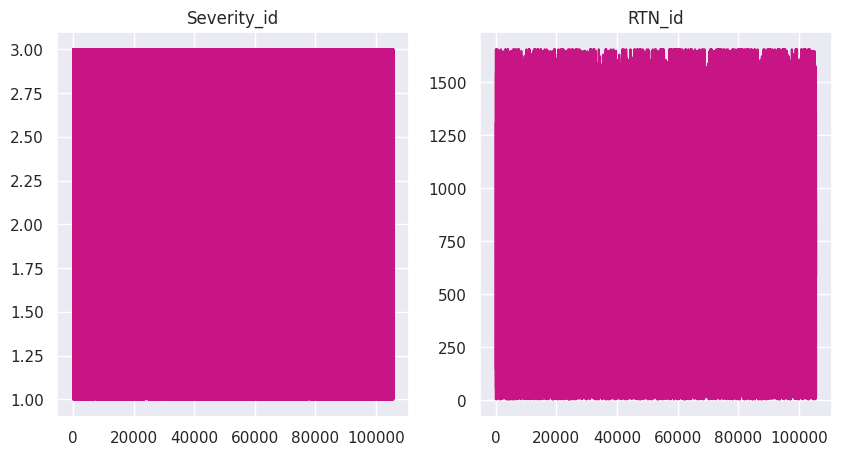

In [84]:
df1 = mw_data['Severity_id']
df2 = mw_data['RTN_id']
#define number of rows and columns for subplots
nrow=1
ncol=2

# make a list of all dataframes 
df_list = [df1 ,df2]
df_title= ['Severity_id','RTN_id']
fig, axes = plt.subplots(nrow, ncol, figsize=(10,5))
i = 0
for x in axes.flatten():
  df_list[i].plot(ax=x, color='mediumvioletred')
  x.set_title(df_title[i])
  i += 1

<ipython-input-85-28de2d6e62c1>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(mw_data.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')


<Axes: >

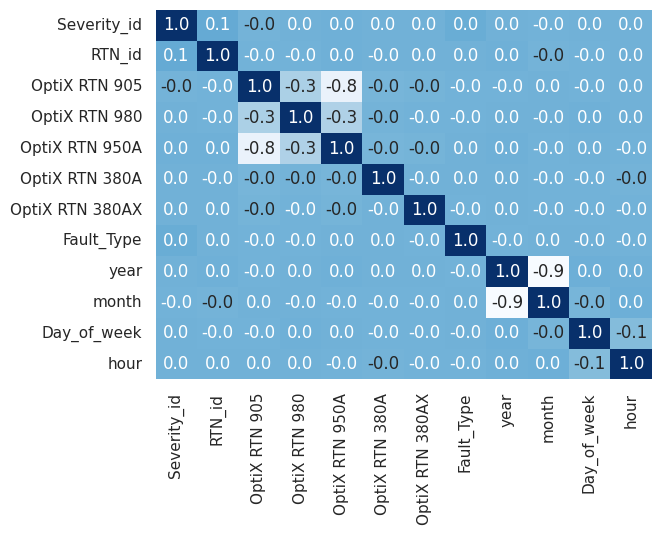

In [85]:
sns.heatmap(mw_data.corr(),annot=True, cbar=False, cmap='Blues', fmt='.1f')

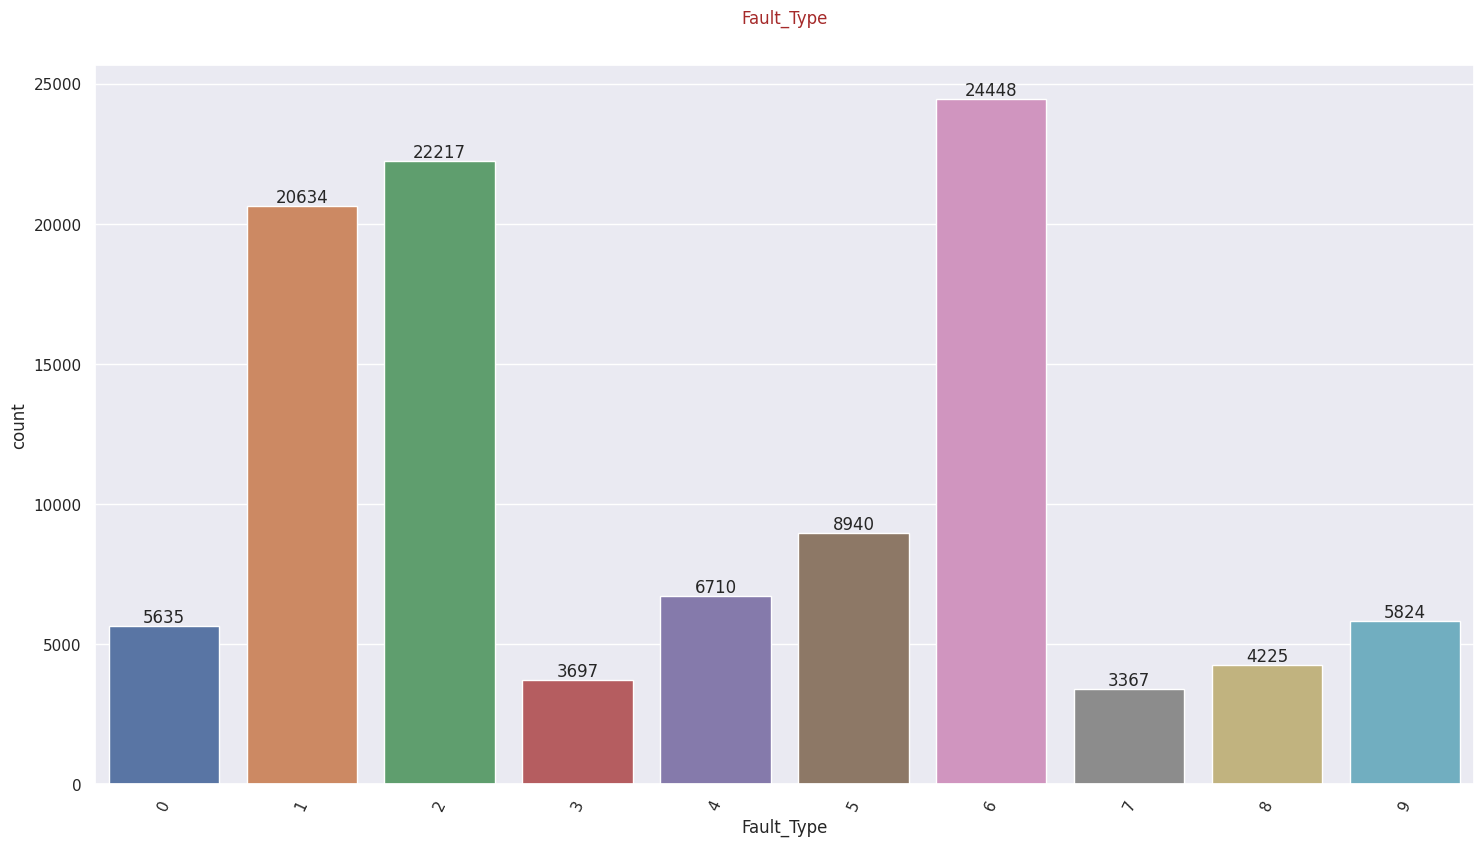

In [87]:
ax = plt.figure(figsize = (15,16))
ax = plt.subplot(2,1,1)
ax = sns.countplot(x='Fault_Type', data=mw_data)
ax.bar_label(ax.containers[0])
plt.title("Fault_Type", fontsize=30,color = 'Brown',font='Lucida Calligraphy',pad=30)
plt.xticks(rotation=65)
plt.tight_layout()


# Prepare training and testing data

In [88]:
train_data,test_data =mw_data[1:84557], mw_data[84557:] 

In [89]:
def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(Date[start:end], series[start:end],format)
    plt.xlabel('Date')
    plt.ylabel('Fault_Type')
    plt.grid(True)

In [91]:
train_data_without_ds = train_data.drop(columns=['Date'])
train_data_without_ds
test_data_without_ds = test_data.drop(columns=['Date'])
test_data_without_ds

,Severity_id,RTN_id,OptiX RTN 905,OptiX RTN 980,OptiX RTN 950A,OptiX RTN 380A,OptiX RTN 380AX,Fault_Type,year,month,Day_of_week,hour
84557,2,1465,0,0,1,0,0,9,2023,3,2,5
84558,3,1061,1,0,0,0,0,6,2023,3,2,5
84559,3,1347,0,0,1,0,0,6,2023,3,2,5
84560,3,1030,0,0,1,0,0,6,2023,3,2,5
84561,3,177,0,0,1,0,0,6,2023,3,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...
105692,3,19,1,0,0,0,0,1,2023,3,4,23
105693,1,966,1,0,0,0,0,2,2023,3,4,23
105694,3,808,1,0,0,0,0,6,2023,3,4,23
105695,3,583,1,0,0,0,0,0,2023,3,4,23


In [95]:
# Hyper parameters
########
num_of_feature = 12 # number of input features for LSTM and GRU network
past_observation = 24 # Number of past hours data used as input to the LSTM and GRU network
##########

######## Model Parameters # 
hidden_layers_unit = [128, 64,32,16]
return_sequence = [True, True, True,False]
batch_size = 64
num_of_epoch = 300


In [96]:
# Values of the attribute are in different scales. For example, holiday has maximum value 1 and traffic volume let say, 2000. Since these values are totally different range, it might be hurt model learning process. To overcome this issue, we need to do data normalization or standarization.
sc = MinMaxScaler()
sc_test = MinMaxScaler()
training_data_set = sc.fit_transform(train_data_without_ds)
training_data_frame = pd.DataFrame(training_data_set)
test_data_set = sc_test.fit_transform(test_data_without_ds)
test_data_frame = pd.DataFrame(test_data_set)


In [97]:
# Make data for the LSTM model. I used past t-hours of data to predict the next 'n' hours data. Here window_size means window size data will be used for predicting next 'n' hours data

def df_to_x_y(data, window_size=5):
    X = []
    y = []
    for i in range(len(data)-window_size):
        row = [r for r in data[i:i+window_size]]
        X.append(row)
        label = data[i+window_size][num_of_feature-1]
        y.append(label)
    return np.array(X), np.array(y)

X, y = df_to_x_y(training_data_set,past_observation)
X.shape, y.shape

((84532, 24, 12), (84532,))

In [98]:
# X test y Test
X_test, y_test = df_to_x_y(test_data_set, past_observation)
X_test.shape, y_test.shape

((21116, 24, 12), (21116,))

In [99]:
# split data into train test and validation datase
from cgi import test


train_length = int(len(X)*0.9) # 80% trainging
validation_length = int(len(X)*.10) # 10% testing and rest for validation
print(train_length, validation_length, (train_length+validation_length))
X_train, y_train = X[:train_length],y[:train_length]
X_val, y_val = X[train_length:], y[train_length:]

76078 8453 84531


In [100]:
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape)


(((76078, 24, 12), (76078,)), ((8454, 24, 12), (8454,)))

In [101]:
#define LSTM model:


LSTM_Model = Sequential()
LSTM_Model.add(InputLayer((past_observation,num_of_feature)))
for i in range(len(hidden_layers_unit)):
    LSTM_Model.add(LSTM(hidden_layers_unit[i], return_sequences=return_sequence[i]))
LSTM_Model.add(Dense(1))
LSTM_Model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.mean_absolute_percentage_error])
LSTM_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           72192     
                                                                 
 lstm_1 (LSTM)               (None, 24, 64)            49408     
                                                                 
 lstm_2 (LSTM)               (None, 24, 32)            12416     
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 137,169
Trainable params: 137,169
Non-trainable params: 0
_________________________________________________________________


In [102]:
#Define GRU MODEL
GRU_Model = Sequential()
GRU_Model.add(InputLayer((past_observation,num_of_feature)))
for i in range(len(hidden_layers_unit)):
    GRU_Model.add(GRU(hidden_layers_unit[i], return_sequences=return_sequence[i]))
GRU_Model.add(Dense(1))
GRU_Model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.mean_absolute_percentage_error])
GRU_Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 24, 128)           54528     
                                                                 
 gru_1 (GRU)                 (None, 24, 64)            37248     
                                                                 
 gru_2 (GRU)                 (None, 24, 32)            9408      
                                                                 
 gru_3 (GRU)                 (None, 16)                2400      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 103,601
Trainable params: 103,601
Non-trainable params: 0
_________________________________________________________________


In [103]:
LSTM_CheckPoint = ModelCheckpoint(path+'model/model_lstm/', save_best_only=True)
GRU_CheckPoint = ModelCheckpoint(path+'model/model_gru/', save_best_only=True)
earlyStop =  tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, mode='min')


In [ ]:
# Train LSTM Model
LSTM_history = LSTM_Model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_of_epoch, callbacks=[LSTM_CheckPoint, earlyStop], batch_size=batch_size, verbose=0)

In [105]:
# Train GRU Model
GRU_history = GRU_Model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_of_epoch, callbacks=[GRU_CheckPoint, earlyStop], batch_size=batch_size, verbose=0)

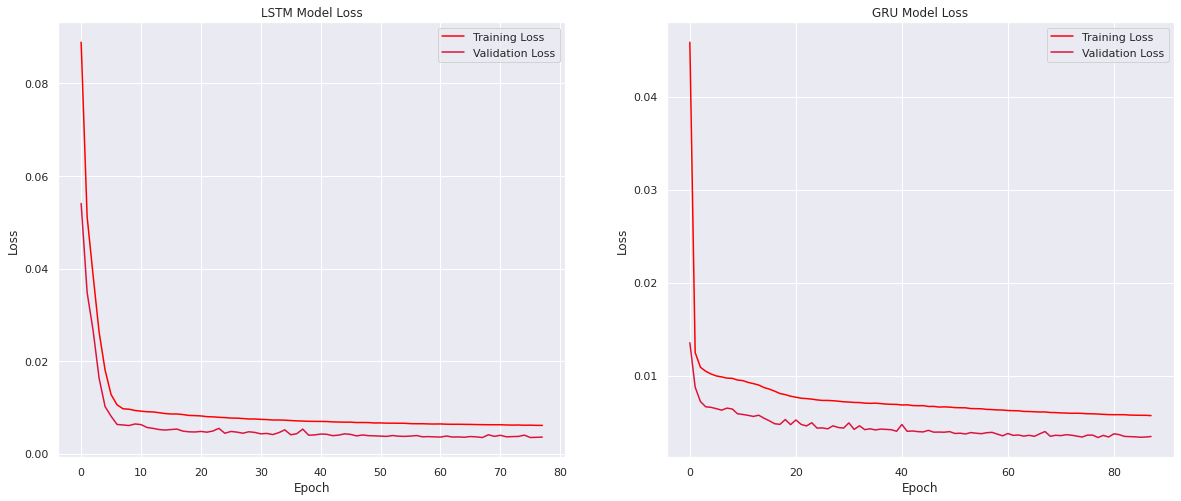

In [ ]:

# summarize history for loss
fig, ax = plt.subplots(1,2,figsize=(20,8))
ax[0].plot(LSTM_history.history['loss'], color='red')
ax[0].plot(LSTM_history.history['val_loss'], color='crimson')
ax[0].set_title('LSTM Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training Loss', 'Validation Loss'], loc='upper right')

ax[1].plot(GRU_history.history['loss'], color='red')
ax[1].plot(GRU_history.history['val_loss'], color='crimson')
ax[1].set_title('GRU Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.savefig(path+"images/training_loss.png", dpi=600)
plt.show()

In [ ]:
# summarize history for loss
fig, ax = plt.subplots(2,2, figsize=(20,8))
ax[0][0].plot(LSTM_history.history['mean_absolute_error'], color='red')
ax[0][0].plot(LSTM_history.history['val_mean_absolute_error'], color='crimson')
ax[0][0].set_title('Mean Absolute Error (LSTM)')
ax[0][0].set_ylabel('Error')
ax[0][0].set_xlabel('Epoch')
ax[0][0].legend(['Training Error', 'Validation Error'], loc='upper right')

ax[0][1].plot(LSTM_history.history['mean_absolute_percentage_error'], color='red')
ax[0][1].plot(LSTM_history.history['val_mean_absolute_percentage_error'], color='crimson')
ax[0][1].set_title('Mean Absolute Percentatge Error (LSTM)')
ax[0][1].set_ylabel('Error')
ax[0][1].set_xlabel('Epoch')
ax[0][1].legend(['Training Error', 'Validation Error'], loc='upper right')


ax[1][0].plot(GRU_history.history['mean_absolute_error'], color='orangered')
ax[1][0].plot(GRU_history.history['val_mean_absolute_error'], color='firebrick')
ax[1][0].set_title('Mean Absolute Error (GRU)')
ax[1][0].set_ylabel('Loss')
ax[1][0].set_xlabel('Epoch')
ax[1][0].legend(['Training Loss', 'Validation Loss'], loc='upper right')

ax[1][1].plot(GRU_history.history['mean_absolute_percentage_error'], color='orangered')
ax[1][1].plot(GRU_history.history['val_mean_absolute_percentage_error'], color='firebrick')
ax[1][1].set_title('Mean Absolute Percentatge Error (GRU)')
ax[1][1].set_ylabel('Error')
ax[1][1].set_xlabel('Epoch')
ax[1][1].legend(['Training Error', 'Validation Error'], loc='upper right')
fig.tight_layout()
plt.savefig(path+"images/mean_absolute_error_loss.png", dpi=600)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
lstm_model = load_model(path+'model/model_lstm/')
gru_model = load_model(path+'model/model_gru/')

In [ ]:
lstm_prediction = lstm_model.predict(X_test)
gru_prediction = gru_model.predict(X_test)

In [ ]:
from tabnanny import verbose


lstm_evaluation = lstm_model.evaluate(X_test, y_test, verbose=0)
gru_evaluation = gru_model.evaluate(X_test, y_test, verbose=0)

In [ ]:
(lstm_evaluation, gru_evaluation)

([0.00444092508405447, 0.04480208083987236, 13054.84765625],
 [0.004220479633659124, 0.043529968708753586, 5820.74462890625])

In [ ]:
print(f'LSTM: Loss: {np.round(lstm_evaluation[0],4)}, Mean Absolute Error: {np.round(lstm_evaluation[1],4)}, MAPE: {np.round(lstm_evaluation[2],4)}')
print(f'GRU: Loss: {np.round(gru_evaluation[0],4)}, Mean Absolute Error: {np.round(gru_evaluation[1],4)}, MAPE: {np.round(gru_evaluation[2],4)}')

LSTM: Loss: 0.0044, Mean Absolute Error: 0.0448, MAPE: 13054.8477
GRU: Loss: 0.0042, Mean Absolute Error: 0.0435, MAPE: 5820.7446


In [ ]:
lstm_Y = np.repeat(lstm_prediction, num_of_feature, axis=1)
lstm_y_inverse = sc_test.inverse_transform(lstm_Y)
gru_Y = np.repeat(gru_prediction, num_of_feature, axis=1)
gru_y_inverse = sc_test.inverse_transform(gru_Y)

In [ ]:
Y_test = np.repeat(y_test, num_of_feature)
Y_test = Y_test.reshape(-1,num_of_feature)
Y_Test_transfer = sc_test.inverse_transform(Y_test)

In [ ]:
lstm_Y_pred = lstm_y_inverse[:, 7]
gru_Y_pred = gru_y_inverse[:,7]
actual_Y_test = Y_Test_transfer[:, 7]

In [ ]:
def plot_series(time, series_true, series_pred, format='-', start=0, end=None):
    plt.plot(time[start:end], series_true[start:end],format)
    plt.plot(time[start:end], series_pred[start:end],format)
    plt.xlabel('Time')
    plt.ylabel('Traffic Volume')
    plt.grid(True)
    plt.show()

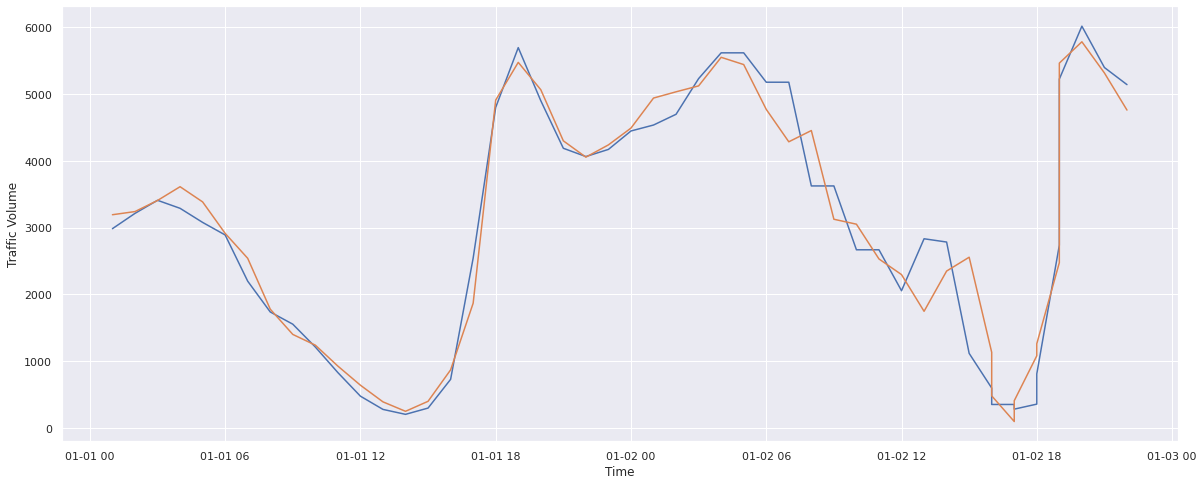

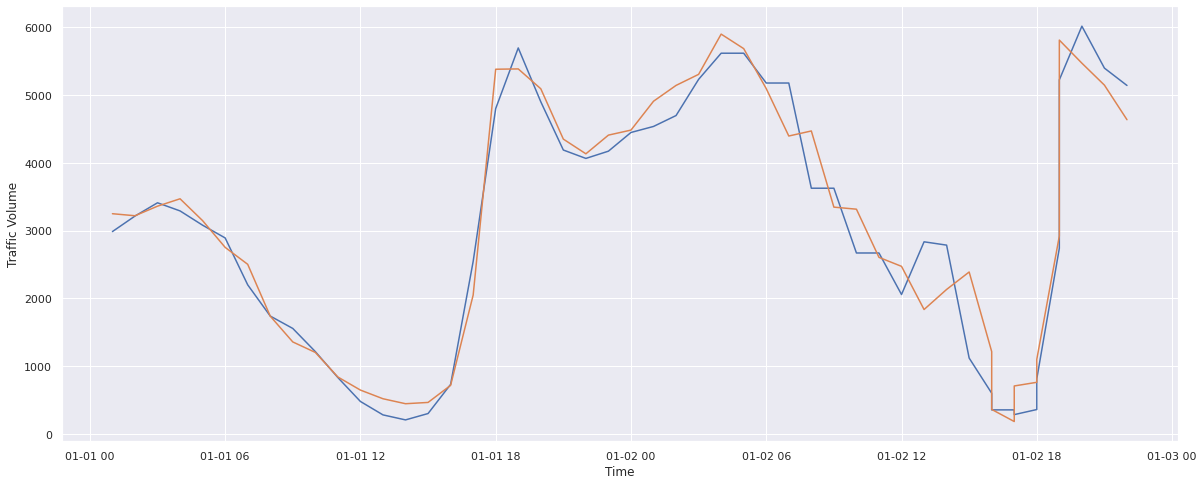

In [ ]:
lstm_y_pred = np.array(lstm_Y_pred)
gru_y_pred = np.array(gru_Y_pred)
y_true = np.array(actual_Y_test)

time_test = np.array(test_data['ds'])

plt.figure(figsize=(20,8))
plot_series(time_test[:50], y_true[:50],lstm_y_pred[:50])
plt.figure(figsize=(20,8))
plot_series(time_test[:50], y_true[:50],gru_y_pred[:50])

In [ ]:
def plot_series_subplot(time, series_true, series_pred, ax,title="",format='-', start=0, end=None):
    xlabels = [str(time[i])[0:13] for i in range(len(time))]
    ax.plot(time[start:end], series_true[start:end],format)
    ax.plot(time[start:end], series_pred[start:end],format)
    ax.set_xlabel('Time')
    ax.set_title(title)
    #ax.set_xticks(time[start:end])
    ax.set_xticklabels(xlabels, rotation=50)
    ax.legend(['Actual','Predicted'], loc='best')
    ax.set_ylabel('Traffic Volume')
    ax.grid(True)

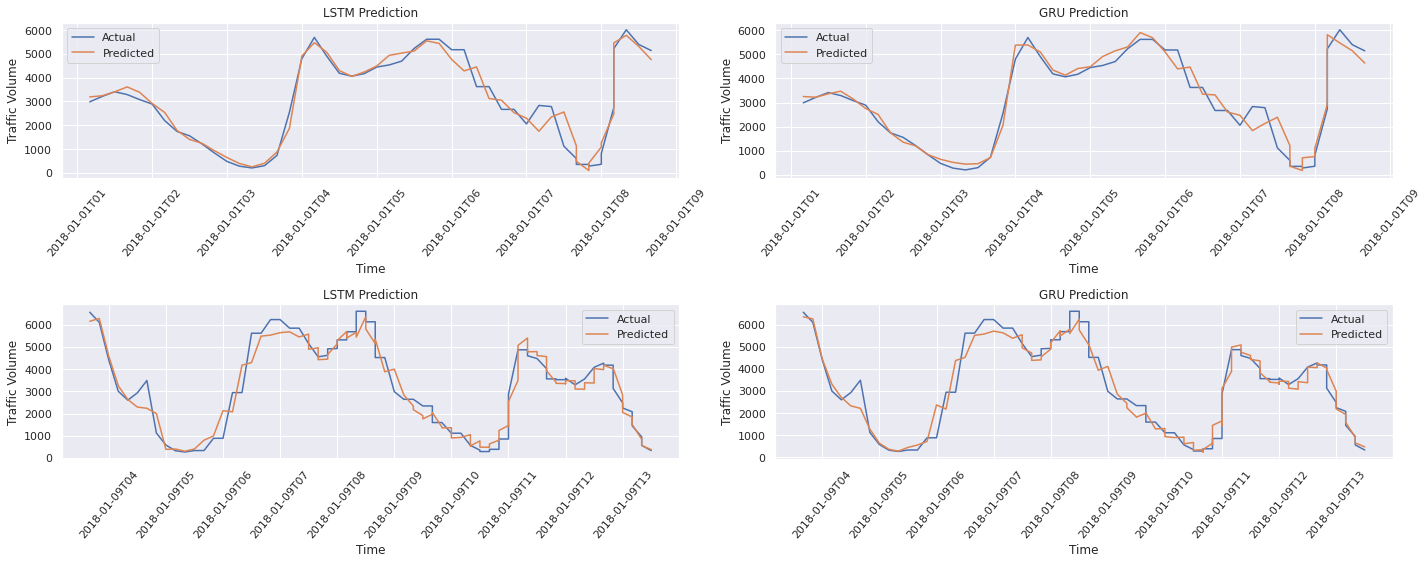

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
plot_series_subplot(time_test[:50], y_true[:50],lstm_y_pred[:50],ax[0][0], "LSTM Prediction")
#plt.figure(figsize=(10,6))
plot_series_subplot(time_test[:50], y_true[:50],gru_y_pred[:50], ax[0][1],"GRU Prediction")
plot_series_subplot(time_test[200:300], y_true[200:300],lstm_y_pred[200:300],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[200:300], y_true[200:300],gru_y_pred[200:300], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig(path+"images/prediction_0.png", dpi=600)

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
plot_series_subplot(time_test[1000:1200], y_true[1000:1200],lstm_y_pred[1000:1200],ax[0][0], "LSTM Prediction")
plot_series_subplot(time_test[1000:1200], y_true[1000:1200],gru_y_pred[1000:1200], ax[0][1],"GRU Prediction")

plot_series_subplot(time_test[0:500], y_true[0:500],lstm_y_pred[0:500],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[0:500], y_true[0:500],gru_y_pred[0:500], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig(path+"images/prediction_1.png", dpi=600)

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
plot_series_subplot(time_test[50:80], y_true[50:80],lstm_y_pred[50:80],ax[0][0], "LSTM Prediction")
plot_series_subplot(time_test[50:80], y_true[50:80],gru_y_pred[50:80], ax[0][1],"GRU Prediction")

plot_series_subplot(time_test[100:120], y_true[100:120],lstm_y_pred[100:120],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[100:120], y_true[100:120],gru_y_pred[100:120], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig(path+"images/prediction_2.png", dpi=600)

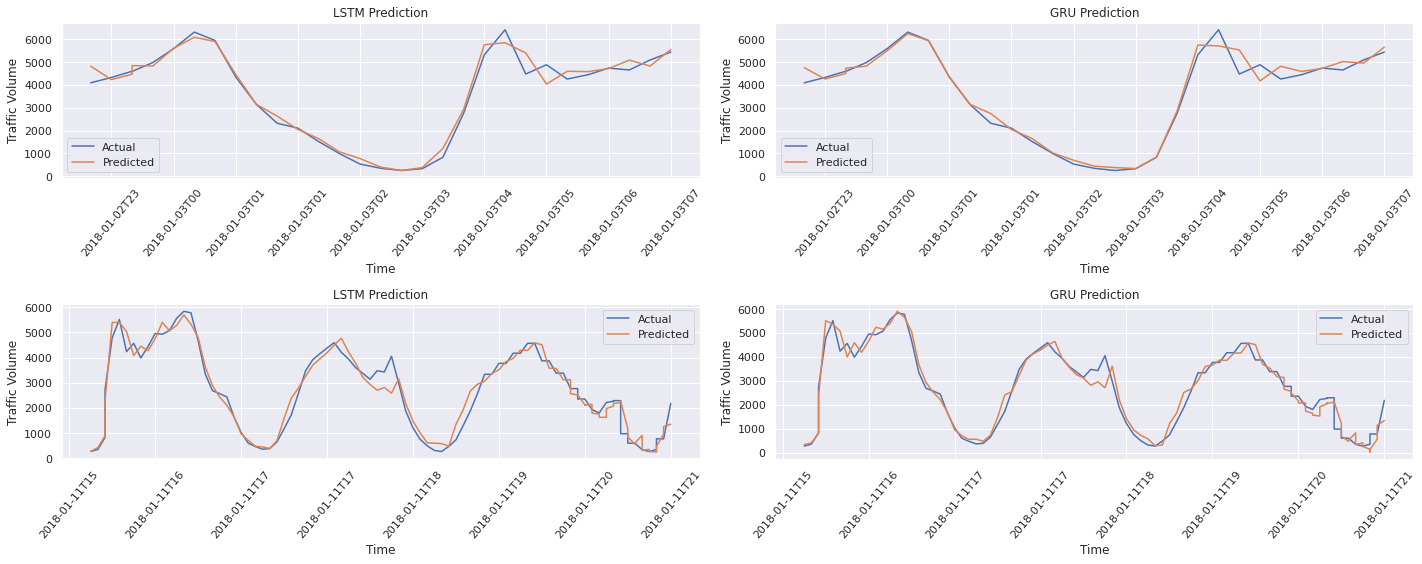

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
plot_series_subplot(time_test[50:80], y_true[50:80],lstm_y_pred[50:80],ax[0][0], "LSTM Prediction")
plot_series_subplot(time_test[50:80], y_true[50:80],gru_y_pred[50:80], ax[0][1],"GRU Prediction")

plot_series_subplot(time_test[300:400], y_true[300:400],lstm_y_pred[300:400],ax[1][0], "LSTM Prediction")
plot_series_subplot(time_test[300:400], y_true[300:400],gru_y_pred[300:400], ax[1][1],"GRU Prediction")
fig.tight_layout()
plt.savefig(path+"images/prediction_3.png", dpi=600)